In [ ]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import importlib
from warnings import simplefilter
from six import StringIO
from IPython.display import Image

# Reload external files
import importlib

# Mute warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

import datetime

from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import os

# Load data

In [ ]:
# Change function of EOD because we use Compustat....
# In the end, add all used Excel files to this repo, we have: stock_universe_new.joblib, SP500H_EOD_raw, SP500H_RP_SESI (if we only use daily SESI score and no other sentiment feature types)
# We use EOD for the list of historical components
# At the end, just do all data steps one more time 

In [ ]:
# Choose data location, EOD, SQL or CSV, Compustat
str_load_data = "CSV"

In [ ]:
# This entire notebook should go in a separate ipynb file later

# Loads raw data, data cleaning and transformation is needed after this
import Load_data
importlib.reload(Load_data)

if str_load_data == "EOD_old_method":
    
    # Index name 
    str_index_name = "S&P500_historical"

    # Loads market data from EOD
    ar_index, df_index = Load_data.create_stock_universe_old(str_index_name)
    df = Load_data.load_EOD(ar_index)

    df = Load_data.create_historical_SP_Index_old_method(df_index, df)            

    # Adds lags and returns
    df = Load_data.add_lags(df)

if str_load_data == "EOD_new_method":

    df = Load_data.create_historical_SP_Index()

    # Adds lags and returns
    df = Load_data.add_lags(df)

elif str_load_data == "SQL":
    
    # Name of the dataframe
    str_table_name = "SP500H_RP_raw"

    # Specify column subset, None if all columns should be loaded
    str_column_subset = "[TIMESTAMP_TZ], [RP_ENTITY_ID], [ENTITY_NAME], [EVENT_SENTIMENT], [EVENT_RELEVANCE], [EVENT_SIMILARITY_DAYS]"

    # Loads the dataframe from SQL
    df = Load_data.load_SQL(str_table_name, str_column_subset)

elif str_load_data == "CSV":

    df_full = Load_data.load_csv("df_Compustat_SPH")

# Check the number of unique elements of SymbolExchangeCode for every BarDate
# df_test = df.groupby("BarDate")["Ticker"].nunique()

# Plot the number of unique elements of SymbolExchangeCode for every BarDate
# df.groupby("BarDate")["Ticker"].nunique().plot()

In [ ]:
# Change all possible places to df when ready....... (to save space)

### Load market data

In [ ]:
import Load_data
importlib.reload(Load_data)
# Loads raw Compustat data from CSV
df_Compustat_raw = Load_data.load_csv("df_Compustat_raw")
df_Compustat_raw.groupby("BarDate")["Ticker"].nunique().plot()

### Create Historical SP500 index

In [ ]:
import Load_data
importlib.reload(Load_data)
df_Compustat_raw_SPH = Load_data.create_historical_SP_Index_deliver(df_Compustat_raw)

### Add lags, returns and target

In [ ]:
import Load_data
importlib.reload(Load_data)
df_Compustat_raw_SPH_variables = Load_data.add_variables(df_Compustat_raw_SPH)
df_Compustat_raw_SPH_variables.groupby("BarDate")["Ticker"].nunique().plot()

### Load Sentiment data

In [ ]:
import Load_data
importlib.reload(Load_data)
# Loads raw RavenPack data from CSV
df_RP_raw = Load_data.load_csv("df_RP_raw")

### Create SESI score

In [ ]:
import SESI
importlib.reload(SESI)
# Creates daily SESI score from raw RavenPack data
df_SESI = SESI.SESI(df_RP_raw)
# Adds Ticker column to df_SESI
df_SESI = SESI.add_ticker(df_SESI)
df_SESI["TIMESTAMP_TZ"] = pd.to_datetime(df_SESI["TIMESTAMP_TZ"])
df_SESI.groupby("TIMESTAMP_TZ")["Ticker"].nunique().plot()

### Merge df_SESI and df_market to df and add lagged SESI

In [ ]:
# Takes long to run, +-1100min
# Was very quick with new function (only 3sec)
import Load_data
importlib.reload(Load_data)
df = Load_data.add_SESI(df_Compustat_raw_SPH_variables, df_SESI)

### Load or Save data

In [ ]:
import Load_data
importlib.reload(Load_data)
file_name = "df"
df = Load_data.load_csv(file_name)

# import Save_data
# importlib.reload(Save_data)
# file_name = "df_Compustat_raw_SPH"
# Save_data.save_to_csv(df_Compustat_raw_SPH, file_name)

## Analyze data

In [ ]:
import Analyze_data
importlib.reload(Analyze_data)

# Check the number of unique elements of SymbolExchangeCode for every BarDate
Analyze_data.unique_stocks_by_date(df)

In [ ]:
import Analyze_data
importlib.reload(Analyze_data)

# Plot all stocks
Analyze_data.plot_all_stocks(df, max_AdjustedClose = 2500)

In [ ]:
# Show summary statistics for CS_MedianNextDayReturn
print(df[["PreviousdayReturn", "SESI"]].describe())
temp = df[["PreviousdayReturn", "SESI"]].describe()
temp.to_csv("Descriptive_statistics.csv")

In [ ]:
# count all 0 values in SESI
df[df["SESI"] == 0].count()

In [ ]:
# Get Descriptive Statistics
# Get Descriptive Statistics with 3 decimal places
desc_stats_PDR = df['PreviousdayReturn'].describe().apply(lambda x: format(x, '.3f'))
desc_stats_SESI = df['SESI'].describe().apply(lambda x: format(x, '.3f'))


# Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=False)


# Plot a simple histogram with binsize determined automatically
sns.histplot(df['PreviousdayReturn'], color="b", ax=axes[0])
axes[0].set_xlabel('Returns', fontsize="x-large")
axes[0].set_ylabel('Count', fontsize="x-large")
# axes[0].text(x=0.97, y=0.97, transform=axes[0].transAxes, s=desc_stats_PDR.to_string(), 
#               fontweight='demibold', fontsize=15, verticalalignment='top', horizontalalignment='right', 
#               backgroundcolor='white', color='black')
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")




# # Draw a table of descriptive statistics for PreviousdayReturn
# desc_table_PDR = axes[0].table(cellText=list(map(list, zip(*[desc_stats_PDR.index, desc_stats_PDR.values]))),
#                            colWidths=[0.2, 0.1],
#                            cellLoc = 'center', loc='right')
# desc_table_PDR.auto_set_font_size(False)
# desc_table_PDR.set_fontsize(10)
# desc_table_PDR.scale(0.6, 1.5) # you can adjust the size of the table here





# Plot a kernel density estimate and rug plot
sns.histplot(df['SESI'], color="b", ax=axes[1],  bins=71)
# axes[1].text(x=0.97, y=0.97, transform=axes[1].transAxes, s=desc_stats_SESI.to_string(), 
#               fontweight='demibold', fontsize=15, verticalalignment='top', horizontalalignment='right', 
#               backgroundcolor='white', color='black')
axes[1].set_xlabel('SESI', fontsize="x-large")
axes[1].set_ylabel('Count', fontsize="x-large")
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")


# # Draw a table of descriptive statistics for SESI
# desc_table_SESI = axes[1].table(cellText=list(map(list, zip(*[desc_stats_SESI.index, desc_stats_SESI.values]))),
#                             colWidths=[0.2, 0.1],
#                             cellLoc = 'center', loc='right')
# desc_table_SESI.auto_set_font_size(False)
# desc_table_SESI.set_fontsize(10)
# desc_table_SESI.scale(0.6, 1.5)




plt.tight_layout()

In [ ]:
# Specify which metrics you want to check

bool_dict = {
    'descriptive_stats': True,
    'correlation_matrix': False,
    "histogram": False,
    "boxplot": False,
    "scatterplot": False,
    "lineplot": False,
    "heatmap": False,
    "barplot": False,
    "piechart": False,
    "violinplot": False,
    "kdeplot": False,
    "hexbinplot": False,
    "scatter_matrix": False,
    "parallel_coordinates": False,
    "andrews_curves": False,
    "radviz": False,
    "lag_plot": False,
    "autocorrelation_plot": False,
    "bootstrap_plot": False
}

import Analyze_data
importlib.reload(Analyze_data)

Analyze_data.Data_analysis(df, bool_dict)

## Load prepared data

In [ ]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import importlib
from warnings import simplefilter
from six import StringIO
from IPython.display import Image

# Reload external files
import importlib

# Mute warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

import datetime

from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import os

import pickle

In [ ]:
import Load_data
importlib.reload(Load_data)
file_name = "df"
df = Load_data.load_csv(file_name)
df["BarDate"] = pd.to_datetime(df["BarDate"])

In [ ]:
# # Order df by BarDate and SymbolExchangeCode
# df = df.sort_values(by = ["BarDate", "Ticker"])
# # reset index
# df = df.reset_index(drop = True)

In [ ]:
# First 'Hyperparameter' is the sequence_length/time_steps
time_steps = 3
b_sentiment_score = True
n_past_returns = 1

In [ ]:
# count the number of 1's and 0's in column NextDayDirection
df["NextDayDirection"].value_counts()

In [ ]:
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

avg_return = df.groupby('BarDate')['NextdayReturn'].mean()
# Calculate the log cumulative return
log_cumulative_return = np.log(1 + avg_return).cumsum()

# Print and plot the result
print(log_cumulative_return)

plt.subplots(figsize=(15,6))

plt.plot(log_cumulative_return)


plt.axvspan(datetime.datetime.strptime("01/03/2001", '%d/%m/%Y').date(), datetime.datetime.strptime("30/11/2001", '%d/%m/%Y').date(), color="grey", alpha=0.5)
plt.axvspan(datetime.datetime.strptime("29/02/2020", '%d/%m/%Y').date(), datetime.datetime.strptime("31/03/2020", '%d/%m/%Y').date(), color="grey", alpha=0.5)
plt.axvspan(datetime.datetime.strptime("31/12/2007", '%d/%m/%Y').date(), datetime.datetime.strptime("31/05/2009", '%d/%m/%Y').date(), color="grey", alpha=0.5)


# plt.axvspan(datetime.datetime.strptime("15/06/2000", '%d/%m/%Y').date(), datetime.datetime.strptime("21/01/2010", '%d/%m/%Y').date(), color="red", alpha=0.05, label="Training")
# plt.axvspan(datetime.datetime.strptime("22/01/2010", '%d/%m/%Y').date(), datetime.datetime.strptime("04/05/2012", '%d/%m/%Y').date(), color="blue", alpha=0.05, label="Validation")
# plt.axvspan(datetime.datetime.strptime("05/05/2012", '%d/%m/%Y').date(), datetime.datetime.strptime("07/03/2023", '%d/%m/%Y').date(), color="green", alpha=0.05, label="Test")

plt.fill_between(log_cumulative_return.index, log_cumulative_return.min(), log_cumulative_return, where=log_cumulative_return.index < datetime.datetime.strptime("21/01/2010", '%d/%m/%Y'), color="red", alpha=0.05, label="Training")
plt.fill_between(log_cumulative_return.index, log_cumulative_return.min(), log_cumulative_return, where=(log_cumulative_return.index >= datetime.datetime.strptime("21/01/2010", '%d/%m/%Y')) & (log_cumulative_return.index < datetime.datetime.strptime("04/05/2012", '%d/%m/%Y')), color="blue", alpha=0.05, label="Validation")
plt.fill_between(log_cumulative_return.index, log_cumulative_return.min(), log_cumulative_return, where=log_cumulative_return.index >= datetime.datetime.strptime("04/05/2012", '%d/%m/%Y'), color="green", alpha=0.05, label="Test")


# log_cumulative_return.plot()
# plt.title('Cumulative equally weighted index logreturns', fontsize = "xx-large")
plt.xlabel('Date', fontsize = "x-large")
plt.ylabel('Cumulative logreturns', fontsize = "x-large")

# Increase the size of x and y tick labels
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")

plt.grid(linestyle='dashed', linewidth=0.5)

# # Format the x-axis to display years
# years = mdates.YearLocator()   # every year
# years_fmt = mdates.DateFormatter('%Y')
# plt.gca().xaxis.set_major_locator(years)
# plt.gca().xaxis.set_major_formatter(years_fmt)

plt.show()

## Feature engineering

In [ ]:
percentage_split_number = 0.50 # With the larger SP500H index we might be able to get back to 2008 with a reasonable percentage (0.40 min)
b_MinMaxScaler = True 
b_standardizer = False 

import Data_preparation
importlib.reload(Data_preparation)

# Scale features with MinMaxScaler or standardize features with StandardScaler
df = Data_preparation.feature_scaling(df, b_MinMaxScaler, b_standardizer, percentage_split_number)

# Creates splits and features and target dataframes
X_in_sample, X_test, y_in_sample, y_test, X_train, X_val, y_train, y_val = Data_preparation.create_splits(df, percentage_split_number, model = "not_lstm", b_sentiment_score = b_sentiment_score)

In [ ]:
df.loc[2687942]

In [ ]:
y_test

# Classification models

In [ ]:
# Creates dataframe which will be filled with all predictions
df_classifications = df.loc[:, df.columns.isin(["BarDate", "Ticker", "NextdayReturn", 'Target'])]
df_classifications = df_classifications.tail(len(X_test))

# Creates dataframe which will be filled with all classifications
df_predictions = df.loc[:, df.columns.isin(["BarDate", "Ticker", "NextdayReturn", 'Target'])]
df_predictions = df_predictions.tail(len(X_test))

# Creates dataframe which will be filled with all Accuracy values
df_accuracy = pd.DataFrame({}, index=["All", "Top 10", "Top 20", "Top decile", "Top quintile", "Second quintile", "Third quintile", "Fourth quintile", "Bottom quintile", "Bottom decile", "Bottom 20", "Bottom 10"])
# Expanding window size for predictions in the test set +- 1 year
window_size = 500*500

# Change dtypes to 32 for memory efficiency
df['PreviousdayReturn'] = df['PreviousdayReturn'].astype('float32')
df['PreviousdayReturn_2'] = df['PreviousdayReturn_2'].astype('float32')
df['PreviousdayReturn_3'] = df['PreviousdayReturn_3'].astype('float32')
df["Target"] = df["Target"].astype('float32')
df["SESI"] = df["SESI"].astype('float32')

## Benchmark models

### Logistic Regression

In [ ]:
import Logistic_regression
importlib.reload(Logistic_regression)

ar_classifications_lr, ar_predictions_lr, model_lr = Logistic_regression.logistic_regression(window_size, y_in_sample, X_in_sample, y_test, X_test)

# Add predictions to df_predictions
df_predictions["predictions_lr"] = ar_predictions_lr
# Add classifications to df_classifications
df_classifications["classifications_lr"] = ar_classifications_lr

In [ ]:
print("coefficients", model_lr.coef_)
print("intercept", model_lr.intercept_)

In [ ]:
import Evaluation_metrics
importlib.reload(Evaluation_metrics)

predictions_accuracy = Evaluation_metrics.prediction_metrics(df_classifications, str_model = "lr", str_single_metric = "Accuracy")

# Add predictions to df_predictions
df_accuracy["Logistic Regresion"] = predictions_accuracy

### Logistic Regression with ENet

In [ ]:
# import ENet
# importlib.reload(ENet)

# # Specify the grid
# grid = {"l1_ratio": [0.3, 0.5, 0.7], "C": np.logspace(start=-40, stop=-10, num=10, base=10)}
# # Predictions 
# performances_ENet, best_model_ENet = ENet.ENet_tune(X_train, y_train, X_val, y_val, grid)

In [ ]:
# # At the moment this returns 50% proba always, not sure if ENEt a good model for our features
# # Or something is wrong with the code

# import ENet
# importlib.reload(ENet)

# ar_classifications_enet, ar_predictions_enet, model_enet = ENet.ENet_test(best_model_ENet, window_size, y_in_sample, X_in_sample, y_test, X_test)

# # Add predictions to df_predictions
# df_predictions["predictions_enet"] = ar_predictions_enet
# # Add classifications to df_classifications
# df_classifications["classifications_enet"] = ar_classifications_enet

In [ ]:
# import Evaluation_metrics
# importlib.reload(Evaluation_metrics)

# predictions_accuracy = Evaluation_metrics.prediction_metrics(df_classifications, str_model = "enet", str_single_metric = "Accuracy")

# # Add predictions to df_predictions
# df_accuracy["Elastic Net"] = predictions_accuracy

### Random Forests

In [ ]:
import sklearn
print(sklearn.__version__)

# Should be 1.2.2

In [ ]:
# 234min for PC1, (with tuning 4*4 combinations), with SESI
# 120min for PC3, Without SESI
# 160min for PC2, Without SESI

import RF
importlib.reload(RF)

# Specify the grid 
# n_jobs = -1 makes use of all cores
# When setting max_depth > 2 and more then 100000 rows, the kernel crashes
# Try a different RF package?
grid = {"n_estimators": [500, 700, 900],   
        "max_depth": [2, 4, 6, 8]}
                                                  #"max_features":    [3, 5, 10]} # Not needed because we only have 4 features
# Predictions 
performances_RF, best_model_RF =  RF.RF_tune(X_train, y_train, X_val, y_val, grid)   #RF.RF_tune(X_train_1000, y_train_1000, X_val_1000, y_val_1000, grid)                       #RF.RF_tune(X_train, y_train, X_val, y_val, grid)

In [ ]:
# 213min for PC1, with SESI
# 120min for PC3, Without SESI
# 220min for PC2, Without SESI

import RF
importlib.reload(RF)

ar_classifications_rf, ar_predictions_rf, model_rf = RF.RF_test(best_model_RF, window_size, y_in_sample, X_in_sample, y_test, X_test)

# Add predictions to df_predictions
df_predictions["predictions_rf"] = ar_predictions_rf
# Add classifications to df_classifications
df_classifications["classifications_rf"] = ar_classifications_rf

In [ ]:
import Evaluation_metrics
importlib.reload(Evaluation_metrics)

predictions_accuracy = Evaluation_metrics.prediction_metrics(df_classifications, str_model = "rf", str_single_metric = "Accuracy")

# Add predictions to df_predictions
df_accuracy["Random Forest"] = predictions_accuracy

### Gradient Boosting Classifier

In [ ]:
# 210min for PC1, with SESI
# 160min for PC3, without SESI
# 180min for PC2, Without SESI

import GBC
importlib.reload(GBC)

# Specify the grid 
grid = {"n_estimators": [100, 200, 500],
        "learning_rate":[0.01, 0.1, 0.2],
        "max_depth": [1, 2, 3]}
# Predictions 
performances_GBC, best_model_GBC = GBC.GBC_tune(X_train, y_train, X_val, y_val, grid)

In [ ]:
# ... min for PC1, with SESI
# 35 min for PC3, Without SESI
# 40min for PC2, Without SESI

import GBC
importlib.reload(GBC)

ar_classifications_gbc, ar_predictions_gbc, model_gbc = GBC.GBC_test(best_model_GBC, window_size, y_in_sample, X_in_sample, y_test, X_test)

# Add predictions to df_predictions
df_predictions["predictions_gbc"] = ar_predictions_gbc
# Add classifications to df_classifications
df_classifications["classifications_gbc"] = ar_classifications_gbc

In [ ]:
import Evaluation_metrics
importlib.reload(Evaluation_metrics)

predictions_accuracy = Evaluation_metrics.prediction_metrics(df_classifications, str_model = "gbc", str_single_metric = "Accuracy")

# Add predictions to df_predictions
df_accuracy["Gradient Boosting Classifier"] = predictions_accuracy

## LSTM (and SimpleRNN) model

In [ ]:
# # Load LSTM data from pickles
directory = r"C:\Users\BasPeeters\OneDrive - FactorOrange.capital\Master Thesis\Dataframes and output"
folder_name = f"lstm_sequences\SESI={b_sentiment_score}_time_steps={time_steps}"
full_directory = os.path.join(directory, folder_name)

names = ['X_in_sample_lstm', 'X_test_lstm', 'y_in_sample_lstm', 'y_test_lstm', 'X_train_lstm', 'X_val_lstm', 'y_train_lstm', 'y_val_lstm', "df_y_test_lstm"]
variables = []
for name in names:
    with open(os.path.join(full_directory, f"{name}.pkl"), 'rb') as f:
        var = pickle.load(f)
        variables.append(var)

X_in_sample_lstm, X_test_lstm, y_in_sample_lstm, y_test_lstm, X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm, df_y_test_lstm = variables
del variables




# Takes 10min

# # Unclear if this is needed, maybe using 3 lags with time steps is also good, test this
# import LSTM
# importlib.reload(LSTM)

# # Creates splits and features and target dataframes
# model = "lstm"
# X_in_sample, X_test, y_in_sample, y_test, X_train, X_val, y_train, y_val = Data_preparation.create_splits(df, percentage_split_number, model, b_sentiment_score)

# # Type should be multi_index_dataframe or 3D_array
# X_in_sample_lstm, X_test_lstm, y_in_sample_lstm, y_test_lstm, X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm, df_y_test_lstm = LSTM.data_preparation(X_in_sample, X_test, y_in_sample, y_test, X_train, X_val, y_train, y_val, time_steps, b_sentiment_score, n_past_returns)

# # Check if df_accuracy exists, if not create it
# try:
#     df_accuracy
# except NameError:
#     # Creates dataframe which will be filled with all Accuracy values
#     df_accuracy = pd.DataFrame({}, index=["All", "Top 10", "Top 20", "Top decile", "Top quintile", "Second quintile", "Third quintile", "Fourth quintile", "Bottom quintile", "Bottom decile", "Bottom 20", "Bottom 10"])


# the X and y sets must be of equal length
print(len(X_val_lstm))
print(len(X_train_lstm))
print(len(X_test_lstm))
print(len(X_in_sample_lstm))

print(len(y_val_lstm))
print(len(y_train_lstm))
print(len(y_test_lstm))
print(len(y_in_sample_lstm))

In [ ]:
# The custom loss is not yet entirely perfect, now it considers batches of 500 stocks and calculates deciles from these 500, but not necessarily on 1 time period
loss_function = 'binary_crossentropy'  # or "custom_loss"
# Type of RNN: "SimpleRNN", "LSTM" or "GRU"
str_nn_type = "SimpleRNN"

In [ ]:
# Turn of printing for PC1??? It prints a lot of shit 
# 185min for PC1, with SESI

# Takes #Epochs * #Tuning parameters * 1min to run  approximately

import LSTM
importlib.reload(LSTM)

# Specify the grid 
# 18ms/step with dropout=0.1 and recurrent_dropout=0.1
# 8ms/step with dropout=0.1 and recurrent_dropout=0.0
grid ={ "n_nodes": [25, 64],
        "dropout": [0.1], # Fischer uses 0.1                                                                             # Not much difference   
        "recurrent_dropout": [0, 0.1],     #[0, 0.1], # Fischer uses 0.1 (after hyperparameter tuning)                                                                   # Adding recurrent_dropout makes the model 2.25 times slower   
        "learning_rate": [0.001, 0.01],          #[0.1, 0.01, 0.001], # 0.001 is default for RMSprop and adam (also seemed best)                                              # learning_rate smaller should take longer to run but I do not see any difference here for values  0.1, 0.01, 0.001, 0.0001
        "batch_size": [32, 64],     #[32, 64], # Default is 32                                                                              # Twice as fast with a twice as big batch size
        "optimizer" : ["RMSprop"], # RMSprop Not default but used bij Fisher and good for RNN, default is adam             # adam seems eually fast as RMSprop                
        "sequence_length": [time_steps] # 250 is roughly 1 year of data
        } 

# Because the loss function needs this
if loss_function == "custom_loss":
    grid["batch_size"] = [500]

if str_nn_type == "LSTM":
    # Trains model on validation set
    performances_LSTM, best_model_LSTM = LSTM.LSTM_tune(X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, grid, b_sentiment_score, n_past_returns, loss_function, str_nn_type) 
    # Plot the training and validation loss for the best model also return the best model
    LSTM.plot_train_val_loss(performances_LSTM)    
if str_nn_type == "SimpleRNN":
    # Trains model on validation set
    performances_RNN, best_model_RNN = LSTM.LSTM_tune(X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, grid, b_sentiment_score, n_past_returns, loss_function, str_nn_type) 
    # Plot the training and validation loss for the best model also return the best model
    LSTM.plot_train_val_loss(performances_RNN)       

In [ ]:
if str_nn_type == "LSTM":
    # Creates dataframe which will be filled with all predictions
    df_classifications_lstm = df_y_test_lstm.copy()
    # Join the column NextdayReturn from df to df_classifications_lstm by BarDate and Ticker
    df_classifications_lstm = df_classifications_lstm.join(df.loc[:, df.columns.isin(["BarDate", "Ticker", "NextdayReturn"])].set_index(["BarDate", "Ticker"]), on=["BarDate", "Ticker"])
    # Creates dataframe which will be filled with all classifications
    df_predictions_lstm = df_y_test_lstm.copy()
    # Join the column NextdayReturn from df to df_classifications_lstm by BarDate and Ticker
    df_predictions_lstm = df_predictions_lstm.join(df.loc[:, df.columns.isin(["BarDate", "Ticker", "NextdayReturn"])].set_index(["BarDate", "Ticker"]), on=["BarDate", "Ticker"])
elif str_nn_type == "SimpleRNN":
    # Creates dataframe which will be filled with all predictions
    df_classifications_rnn = df_y_test_lstm.copy()
    # Join the column NextdayReturn from df to df_classifications_lstm by BarDate and Ticker
    df_classifications_rnn = df_classifications_rnn.join(df.loc[:, df.columns.isin(["BarDate", "Ticker", "NextdayReturn"])].set_index(["BarDate", "Ticker"]), on=["BarDate", "Ticker"])
    # Creates dataframe which will be filled with all classifications
    df_predictions_rnn = df_y_test_lstm.copy()
    # Join the column NextdayReturn from df to df_classifications_lstm by BarDate and Ticker
    df_predictions_rnn = df_predictions_rnn.join(df.loc[:, df.columns.isin(["BarDate", "Ticker", "NextdayReturn"])].set_index(["BarDate", "Ticker"]), on=["BarDate", "Ticker"])

In [ ]:
# Takes 160 minutes to run
# Takes #Epochs times 5 times 70sec to run

import LSTM
importlib.reload(LSTM)

if str_nn_type == "LSTM":
    ar_predictions_lstm, ar_classifications_lstm, model_lstm = LSTM.LSTM_test(best_model_LSTM, window_size, y_in_sample_lstm, X_in_sample_lstm, y_test_lstm, X_test_lstm, b_sentiment_score, n_past_returns, loss_function, str_nn_type) 
    df_predictions_lstm["predictions_lstm"] = ar_predictions_lstm
    df_classifications_lstm["classifications_lstm"] = ar_classifications_lstm
elif str_nn_type == "SimpleRNN":
    ar_predictions_rnn, ar_classifications_rnn, model_rnn = LSTM.LSTM_test(best_model_RNN, window_size, y_in_sample_lstm, X_in_sample_lstm, y_test_lstm, X_test_lstm, b_sentiment_score, n_past_returns, loss_function, str_nn_type) 
    df_predictions_rnn["predictions_rnn"] = ar_predictions_rnn
    df_classifications_rnn["classifications_rnn"] = ar_classifications_rnn

In [ ]:
# Joins LSTM predictions and classifications to df_predictions and df_classifications

if str_nn_type == "LSTM":
    # left join column classifications_lstm from df_classifications_lstm to df_classifications by BarDate and Ticker
    df_classifications = df_classifications.join(df_classifications_lstm.loc[:, df_classifications_lstm.columns.isin(["BarDate", "Ticker", "classifications_lstm"])].set_index(["BarDate", "Ticker"]), on=["BarDate", "Ticker"])
    df_classifications = df_classifications.dropna()
    del df_classifications_lstm
    # left join column classifications_lstm from df_classifications_lstm to df_classifications by BarDate and Ticker
    df_predictions = df_predictions.join(df_predictions_lstm.loc[:, df_predictions_lstm.columns.isin(["BarDate", "Ticker", "predictions_lstm"])].set_index(["BarDate", "Ticker"]), on=["BarDate", "Ticker"])
    df_predictions = df_predictions.dropna()
    del df_predictions_lstm
elif str_nn_type == "SimpleRNN":
    # left join column classifications_lstm from df_classifications_lstm to df_classifications by BarDate and Ticker
    df_classifications = df_classifications.join(df_classifications_rnn.loc[:, df_classifications_rnn.columns.isin(["BarDate", "Ticker", "classifications_rnn"])].set_index(["BarDate", "Ticker"]), on=["BarDate", "Ticker"])
    df_classifications = df_classifications.dropna()
    del df_classifications_rnn
    # left join column classifications_lstm from df_classifications_lstm to df_classifications by BarDate and Ticker
    df_predictions = df_predictions.join(df_predictions_rnn.loc[:, df_predictions_rnn.columns.isin(["BarDate", "Ticker", "predictions_rnn"])].set_index(["BarDate", "Ticker"]), on=["BarDate", "Ticker"])
    df_predictions = df_predictions.dropna()
    del df_predictions_rnn

In [ ]:
import Evaluation_metrics
importlib.reload(Evaluation_metrics)

if str_nn_type == "LSTM":
    predictions_accuracy = Evaluation_metrics.prediction_metrics(df_classifications, str_model = "lstm", str_single_metric = "Accuracy")
    df_accuracy["LSTM"] = predictions_accuracy       # If the backtest is so good but the accuracy in the top 20 not so then something is going wrong here!!!!!!!!! This can be tested by checking the number of longs and shorts above the median in portfolio 

elif str_nn_type == "SimpleRNN":
    predictions_accuracy = Evaluation_metrics.prediction_metrics(df_classifications, str_model = "rnn", str_single_metric = "Accuracy")
    df_accuracy["RNN"] = predictions_accuracy

In [ ]:
df_accuracy

In [ ]:
# This is only the model from the last iteraton of the expanding window!
# If we do Shap values or something then this must be mentioned!!!!!!!!!!!!!!!!!!!!!!!
if str_nn_type == "LSTM":
    model_lstm.summary()
elif str_nn_type == "SimpleRNN":
    model_rnn.summary()

In [ ]:
# %pip uninstall numpy
# %pip install numpy==1.19.5

# import shap

# # We initialize the javascript for SHAP
# shap.initjs()

# X_train_lstm_sample = X_train_lstm[np.random.choice(X_train_lstm.shape[0], 1000, replace=False)]

# # We create an explainer. DeepExplainer works well for deep learning models like LSTM.
# explainer = shap.DeepExplainer(model_lstm, X_train_lstm_sample)

# # Generate SHAP values
# shap_values = explainer.shap_values(X_train_lstm_sample)

# # Convert the input training set to a numpy array
# X_train_array = np.array(X_train_lstm_sample)

# # Summarize the effects of all the features
# shap.summary_plot(shap_values, X_train_array)


# Classification & Prediction analysis

In [ ]:
print(df_classifications["Target"].value_counts())

In [ ]:
for model in ["classifications_lr",  "classifications_rf",  "classifications_gbc", "classifications_rnn",  "classifications_lstm"]:
    print(df_classifications[model].value_counts())

In [ ]:
# Value counts per quantile

df_classifications_predictions = df_classifications.copy()
# left join columns predictions_lr, predictions_rf, predictions_gbc, predictions_lstm from df_predictions to df_classifications_temp by BarDate and Ticker
df_classifications_predictions = df_classifications_predictions.join(df_predictions.loc[:, df_predictions.columns.isin(["BarDate", "Ticker", "predictions_lr", "predictions_rf", 
                                                                                                                        "predictions_gbc", "predictions_rnn", "predictions_lstm"])].set_index(["BarDate", "Ticker"]), on=["BarDate", "Ticker"])

models = ["lr", "rf", "gbc", "rnn", "lstm"]
dict_quantiles = {}
for model in models:

    # Group by date
    grouped = df_classifications_predictions[["BarDate", "Ticker", "Target", f"classifications_{model}", f"predictions_{model}"]].groupby("BarDate")

    # Select top 20, reset index, calculate str_single_metric of quantile
    quantile_top = grouped.apply(lambda x: x.sort_values(by=f"predictions_{model}", 
                                                        ascending=False).iloc[: 20])
    quantile_top = quantile_top.reset_index(drop=True)
    # Select top 20, reset index, calculate str_single_metric of quantile
    quantile_bottom = grouped.apply(lambda x: x.sort_values(by=f"predictions_{model}", 
                                                        ascending=False).iloc[int(len(x))-20 : ])
    quantile_bottom = quantile_bottom.reset_index(drop=True)
    quantile = pd.concat([quantile_top, quantile_bottom])
    dict_quantiles[f"quantile_{model}"] = quantile

    # Count the number of 0's and 1's for column classifications_lr in quantile
    print(dict_quantiles[f"quantile_{model}"][f"classifications_{model}"].value_counts())

    dict_quantiles[f"quantile_{model}"][f"error_{model}"] = np.where(dict_quantiles[f"quantile_{model}"]["Target"] == dict_quantiles[f"quantile_{model}"][f"classifications_{model}"], 0, 1)

## Diebold Mariano

In [ ]:
# DM tests!!!!!!!!!
import Evaluation_metrics
importlib.reload(Evaluation_metrics)

str_dm_type = "adjusted"   # "adjusted" or "classic"
str_sample = "Top_bottom_20"        # "full" or "Top_bottom_20"
# Do not use classic in combination with Top_bottom_20!!!!!!!!!!!!! Not possible
dmTable, pValueTable = Evaluation_metrics.Diebold_Mariano(df_classifications, df_predictions, str_dm_type, str_sample)

# Portfolio backtests

In [ ]:
#### Portfolio part code needs to be adjusted maybe, seminar model

## Write code here to load gb, lr, rf predictions

In [ ]:
# long_only = True
# short_only = False

# # Number of long and short stocks
# n_both = 20
# n_long = n_both
# n_short = n_both

# Choose which models we want
backtest_models = ["lr", "rf", "gbc", "rnn", "lstm"]                          #"NN1", "NN2", "NN3", "NN4", "NN5"] 
legend_names = ["LR", "RF", "GB", "RNN", "LSTM"]

# Choose weighting method (Equal weighted (Equal) or RankBased weighted (RankBased))
# weighting_method = "Equal" 

dict_df_returns_portfolio = {}
dict_df_metrics = {}	

# # Cumulative return of stock index, used only in plot
# stockindex_returns_cum = (1 + df_stockindex_returns["Return"]).cumprod() - 1
df_stockindex_returns = None

# Define the colors for the lines
# colors = ['red', 'blue', 'green', 'orange', 'red', 'blue', 'green', 'orange']
colors = ['red', 'blue', 'green', 'orange', 'yellow']

# Get factors and rf rate
rf_rate_and_factors = pd.read_csv(os.path.join(r"C:\Users\BasPeeters\OneDrive - FactorOrange.capital\Master Thesis\Dataframes and output", "RF_rate_and_factors.csv"))
rf_rate_and_factors = rf_rate_and_factors['BarDate;Mkt-RF;SMB;HML;RMW;CMA;RF'].str.split(';', expand=True)
rf_rate_and_factors.columns = ['BarDate', 'Mkt_min_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
rf_rate_and_factors['BarDate'] = pd.to_datetime(rf_rate_and_factors['BarDate'], format='%d/%m/%Y')
rf_rate_and_factors = rf_rate_and_factors[rf_rate_and_factors['BarDate'].isin(df_predictions['BarDate'])]
rf_rate_and_factors.reset_index(drop=True, inplace=True)
temp_LT_rev = pd.read_csv(os.path.join(r"C:\Users\BasPeeters\OneDrive - FactorOrange.capital\Master Thesis\Dataframes and output", "LT_Reversal_Factor.csv"))
temp_LT_rev = temp_LT_rev['BarDate;LT_Rev'].str.split(';', expand=True)
temp_LT_rev.columns = ['BarDate', 'LT_Rev']
temp_LT_rev['BarDate'] = pd.to_datetime(temp_LT_rev['BarDate'], format='%d/%m/%Y')
temp_LT_rev = temp_LT_rev[temp_LT_rev['BarDate'].isin(df_predictions['BarDate'])]
temp_LT_rev.reset_index(drop=True, inplace=True)
temp_ST_rev = pd.read_csv(os.path.join(r"C:\Users\BasPeeters\OneDrive - FactorOrange.capital\Master Thesis\Dataframes and output", "ST_Reversal_Factor.csv"))
temp_ST_rev = temp_ST_rev['BarDate;ST_Rev'].str.split(';', expand=True)
temp_ST_rev.columns = ['BarDate', 'ST_Rev']
temp_ST_rev['BarDate'] = pd.to_datetime(temp_ST_rev['BarDate'], format='%d/%m/%Y')
temp_ST_rev = temp_ST_rev[temp_ST_rev['BarDate'].isin(df_predictions['BarDate'])]
temp_ST_rev.reset_index(drop=True, inplace=True)
temp_MOM_rev = pd.read_csv(os.path.join(r"C:\Users\BasPeeters\OneDrive - FactorOrange.capital\Master Thesis\Dataframes and output", "Momentum_Factor.csv"))
temp_MOM_rev = temp_MOM_rev['BarDate;Mom   '].str.split(';', expand=True)
temp_MOM_rev.columns = ['BarDate', 'Mom']
temp_MOM_rev['BarDate'] = pd.to_datetime(temp_MOM_rev['BarDate'], format='%d/%m/%Y')
temp_MOM_rev = temp_MOM_rev[temp_MOM_rev['BarDate'].isin(df_predictions['BarDate'])]
temp_MOM_rev.reset_index(drop=True, inplace=True)


rf_rate_and_factors["ST_Rev"] = temp_ST_rev["ST_Rev"]
rf_rate_and_factors["LT_Rev"] = temp_LT_rev["LT_Rev"]
rf_rate_and_factors["Mom"] = temp_MOM_rev["Mom"]
rf_rate_and_factors[["Mkt_min_RF", "SMB", "HML", "RF", "ST_Rev", "LT_Rev", "Mom"]] = rf_rate_and_factors[["Mkt_min_RF", "SMB", "HML", "RF", "ST_Rev", "LT_Rev", "Mom"]].astype('float32')
rf_rate_and_factors[['Mkt_min_RF', 'SMB', 'HML','RF', "ST_Rev", "LT_Rev", "Mom"]] = rf_rate_and_factors[['Mkt_min_RF', 'SMB', 'HML', 'RF', "ST_Rev", "LT_Rev", "Mom"]] / 100

# Only one spot has NaN values for three factors
rf_rate_and_factors = rf_rate_and_factors.fillna(0)

In [ ]:
# Takes 5:30 to run

# # Creates a matrix with all actual returns only 
# # The last columns are not the last dates. These all seem NaN values.............Something must change...........................
# stocks = df['Ticker'].unique()
# returnsMatrix = pd.DataFrame(index=df_predictions['BarDate'].unique(), columns=stocks)
# for stock in stocks:
#     stock_df = df[df['Ticker'] == stock]
#     for index, row in stock_df.iterrows():
#         returnsMatrix.at[row['BarDate'], stock] = row['NextdayReturn']

# Load returnsMatrix
returnsMatrix = pd.read_csv(os.path.join(r"C:\Users\BasPeeters\OneDrive - FactorOrange.capital\Master Thesis\Dataframes and output", "returnsMatrix.csv"))

In [ ]:
#### later nog metrics opslaan voor long_only and short_only maar pas bij de backtests die we echt gaan gebruiken

In [ ]:
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Extra metrics take long to run
# +- 72min for full run with 10,20,50 and all models

import Portfolio_backtester
importlib.reload(Portfolio_backtester)

# Number of long and short stocks
for n_both in tqdm([10, 20, 50]):                   #([10, 20, 50]):

    #n_both = 20
    n_long = n_both
    n_short = n_both
    n_constituents = n_both * 2
    # Create a loop which first sets long_only = True and then short_only = True and then both = False
    for long_only in tqdm([True, False]):
        for short_only in [True, False]:
            if (long_only == True) & (short_only == True):
                continue
            if long_only == True:
                str_side = "long"
            if short_only == True:
                str_side = "short"
            if (long_only == False) & (short_only == False):
                str_side = "long_short"

            # Plot the cumulative portfolio return
            plt.subplots(figsize=(20,10))
            # Dictionary to be filled with weight matrices
            weight_matrix_dict = {}
            # Use this for color of the lines
            i = 0
            # for weighting_method in tqdm(["Equal", "RankBased"]):
            for weighting_method in ["Equal"]:
                # dict_df_metrics[f"{weighting_method}_{n_both}_{str_side}"] = pd.DataFrame({}, index=["mean_return", 'std_dev', 'information_ratio', "sharpe_ratio", "appraisal_ratio", 'max_drawdown', 'max_1_day_loss', "turnover"])
                dict_df_returns_portfolio[f"{weighting_method}_{n_both}_{str_side}"] = pd.DataFrame({"BarDate": df_predictions["BarDate"].unique()})
                for backtest_model in tqdm(backtest_models):
                    # Predictions are now stored in two different objects
                    # if backtest_model == "lstm":
                    #     df_predictions_backtest = df_predictions_lstm
                    #     df_returns_portfolio_backtest = df_returns_portfolio_lstm

                    predictions_test_set, df_returns_portfolio, str_returns_portfolio_cum, str_logreturns_portfolio_cum, weightMatrix = Portfolio_backtester.backtest(df_predictions,n_long,n_short,backtest_model,
                                                                                    weighting_method, dict_df_returns_portfolio[f"{weighting_method}_{n_both}_{str_side}"], returnsMatrix, long_only, short_only)
                    weight_matrix_dict.update({backtest_model: weightMatrix})     # Weight matrix does not seem correct!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            
                    if weighting_method == "Equal":
                        plt.plot(pd.to_datetime(df_returns_portfolio["BarDate"]), df_returns_portfolio[str_logreturns_portfolio_cum], color = colors[i], label=str(f"{backtest_model} {weighting_method}"))
                    elif(weighting_method == "RankBased"):
                        plt.plot(pd.to_datetime(df_returns_portfolio["BarDate"]), df_returns_portfolio[str_logreturns_portfolio_cum], color = colors[i], linestyle = '--', label=str(f"{backtest_model} {weighting_method}"))
                    # Adds portfolio returns to the dictionary with all portfolio returns
                    dict_df_returns_portfolio[f"{weighting_method}_{n_both}_{str_side}"] = df_returns_portfolio
                    # Gives metrics, now only for the full long-short portfolio
                    # if long_only == True or short_only == True:
                    # dict_df_metrics[f"{weighting_method}_{n_both}_{str_side}"] = Portfolio_backtester.metrics(dict_df_returns_portfolio[f"{weighting_method}_{n_both}_{str_side}"], backtest_model, dict_df_metrics[f"{weighting_method}_{n_both}_{str_side}"], df_stockindex_returns, returnsMatrix, weightMatrix, rf_rate_and_factors)
                    i = i + 1

            #plt.plot(pd.to_datetime(df_stockindex_returns["Date"]), stockindex_returns_cum) # Plots long only index
            plt.axvspan(datetime.datetime.strptime("29/02/2020", '%d/%m/%Y').date(), datetime.datetime.strptime("31/03/2020", '%d/%m/%Y').date(), color="grey", alpha=0.5)
            # plt.axvspan(datetime.datetime.strptime("31/12/2007", '%d/%m/%Y').date(), datetime.datetime.strptime("31/05/2009", '%d/%m/%Y').date(), color="grey", alpha=0.5)

            plt.xlabel(xlabel="Date", fontsize = "x-large")
            if long_only == True:
                plt.ylabel(ylabel="Cumulative (long) logreturns", fontsize = "x-large")
            if short_only == True:
                plt.ylabel(ylabel="Cumulative (short) logreturns", fontsize = "x-large")
            if (long_only == False) & (short_only == False):
                plt.ylabel(ylabel="Cumulative logreturns", fontsize = "x-large")
            plt.title(label=f"Cumulative {n_constituents}-stock portfolio logreturns", fontsize = "xx-large")  
            plt.grid(linestyle='dashed', linewidth=0.5)
            #plt.legend(['lr', 'rf', 'gb', 'lstm', 'lr_rank', 'rf_rank', 'gb_rank', 'lstm_rank'] , loc = 'upper center', ncols = 4, fontsize = 'large')    # Without specifying loc it chooses the best location
            plt.legend(legend_names  , loc = 'upper center', ncols = len(legend_names), fontsize = 'large')    # Without specifying loc it chooses the best location

            # Format the x-axis to display years
            years = mdates.YearLocator()   # every year
            years_fmt = mdates.DateFormatter('%Y')
            plt.gca().xaxis.set_major_locator(years)
            plt.gca().xaxis.set_major_formatter(years_fmt)
            plt.show()

In [ ]:
# Only calculates metrics

import Portfolio_backtester
importlib.reload(Portfolio_backtester)

dict_df_metrics = {}
for n_both in [10, 20, 50]:
    for long_only in [True, False]:
        for short_only in [True, False]:
            if (long_only == True) & (short_only == True):
                continue
            if long_only == True:
                str_side = "long"
            if short_only == True:
                str_side = "short"
            if (long_only == False) & (short_only == False):
                str_side = "long_short"                
            for weighting_method in ["Equal"]:
                dict_df_metrics[f"{weighting_method}_{n_both}_{str_side}"] = pd.DataFrame({}, index=["mean_return", 'std_dev', 'information_ratio', "sharpe_ratio", "appraisal_ratio", 'max_drawdown', 'max_1_day_loss', "turnover"])    
                for backtest_model in (backtest_models):
                    dict_df_metrics[f"{weighting_method}_{n_both}_{str_side}"] = Portfolio_backtester.metrics(dict_df_returns_portfolio[f"{weighting_method}_{n_both}_{str_side}"], backtest_model, dict_df_metrics[f"{weighting_method}_{n_both}_{str_side}"], df_stockindex_returns, returnsMatrix, weightMatrix, rf_rate_and_factors)


In [ ]:
# Only plots figures

import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Extra metrics take long to run
# +- 72min for full run with 10,20,50 and all models

import Portfolio_backtester
importlib.reload(Portfolio_backtester)


# df_returns_portfolio_Equal_10_long_short_SESI
# df_returns_portfolio_Equal_10_long_SESI 
# df_returns_portfolio_Equal_10_short_SESI

# df_returns_portfolio_Equal_10_long_short
# df_returns_portfolio_Equal_10_long
# df_returns_portfolio_Equal_10_short


backtest_models = ["lr", "rf", "gbc", "rnn", "lstm"]                         
# legend_names = ["LR_SESI", "RF_SESI", "GB_SESI", "RNN_SESI", "LSTM_SESI", "LR", "RF", "GB", "RNN", "LSTM"]
legend_names = ["LR_SESI", "LR", "RF_SESI", "RF", "GB_SESI", "GB", "RNN_SESI", "RNN", "LSTM_SESI", "LSTM"] 
# colors = ['red', 'blue', 'green', 'orange', 'yellow', 'red', 'blue', 'green', 'orange', 'yellow']
colors = ['red', 'red', 'blue', 'blue', 'green', 'green', 'orange', 'orange', 'yellow', 'yellow']


str_side = "short"
n_both = 10
n_constituents = 2*n_both



plt.subplots(figsize=(15,6))
i = 0
for backtest_model in tqdm(backtest_models):

    

    for weighting_method in ["Equal"]:
        for b_SESI in [True, False]:
            if b_SESI == True:
                df_returns_portfolio = df_returns_portfolio_Equal_10_short_SESI.copy()
            else:
                df_returns_portfolio = df_returns_portfolio_Equal_10_short.copy()
            str_logreturns_portfolio_cum = "logreturns_" + backtest_model + "_portfolio_cum"
            if b_SESI == True:
                plt.plot(pd.to_datetime(df_returns_portfolio["BarDate"]), df_returns_portfolio[str_logreturns_portfolio_cum], color = colors[i], label=str(f"{backtest_model} {weighting_method}"))
            elif b_SESI == False:
                plt.plot(pd.to_datetime(df_returns_portfolio["BarDate"]), df_returns_portfolio[str_logreturns_portfolio_cum], color = colors[i], linestyle = '--', label=str(f"{backtest_model} {weighting_method}"))
            # Adds portfolio returns to the dictionary with all portfolio returns
            i = i + 1

#plt.plot(pd.to_datetime(df_stockindex_returns["Date"]), stockindex_returns_cum) # Plots long only index
plt.axvspan(datetime.datetime.strptime("29/02/2020", '%d/%m/%Y').date(), datetime.datetime.strptime("31/03/2020", '%d/%m/%Y').date(), color="grey", alpha=0.5)
# plt.axvspan(datetime.datetime.strptime("31/12/2007", '%d/%m/%Y').date(), datetime.datetime.strptime("31/05/2009", '%d/%m/%Y').date(), color="grey", alpha=0.5)

plt.xlabel(xlabel="Date", fontsize = "x-large")
if (str_side == "long"):
    plt.ylabel(ylabel="Cumulative (long) logreturns", fontsize = "x-large")
if (str_side == "short"):
    plt.ylabel(ylabel="Cumulative (short) logreturns", fontsize = "x-large")
if (str_side == "long_short"):
    plt.ylabel(ylabel="Cumulative logreturns", fontsize = "x-large")
# plt.title(label=f"Cumulative {n_constituents}-stock portfolio logreturns", fontsize = "xx-large")  
plt.grid(linestyle='dashed', linewidth=0.5)
#plt.legend(['lr', 'rf', 'gb', 'lstm', 'lr_rank', 'rf_rank', 'gb_rank', 'lstm_rank'] , loc = 'upper center', ncols = 4, fontsize = 'large')    # Without specifying loc it chooses the best location
plt.legend(legend_names  , loc = 'upper center', ncols = 5, fontsize = 'medium')    # Without specifying loc it chooses the best location


# Increase the size of x and y tick labels
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")

# Format the x-axis to display years
years = mdates.YearLocator()   # every year
years_fmt = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.show()


In [ ]:
print(dict_df_metrics["Equal_20_long_short"])
# Check the distribution of column "returns_lr_portfolio" in dict_df_returns_portfolio["Equal_20_long_short"]
print(dict_df_returns_portfolio["Equal_20_long_short"]["returns_lstm_portfolio"].hist(bins=100))
# Check the distribution of column "returns_lr_portfolio" in dict_df_returns_portfolio["Equal_20_long_short"]
print(dict_df_returns_portfolio["Equal_20_long_short"]["returns_lstm_portfolio"].describe())
# Calculate the skewness and kurtosis of dict_df_returns_portfolio["Equal_20_long_short"]["returns_lstm_portfolio"]
# Skewness can be negative because of positive mean
print(skew(dict_df_returns_portfolio["Equal_20_long_short"][["returns_lr_portfolio" ,"returns_rf_portfolio", "returns_gbc_portfolio", "returns_rnn_portfolio" ,"returns_lstm_portfolio"]], axis=0, bias=True))
# Count the number of positive values in a series
print(len(dict_df_returns_portfolio["Equal_20_long_short"]["returns_lstm_portfolio"]))
print(dict_df_returns_portfolio["Equal_20_long_short"]["returns_lstm_portfolio"][dict_df_returns_portfolio["Equal_20_long_short"]["returns_lstm_portfolio"] > 0].count())

In [ ]:
# count the number of rows for each year of the dataframe
print("Trading days per year")
dict_df_returns_portfolio["Equal_20_long_short"].groupby(dict_df_returns_portfolio["Equal_20_long_short"]["BarDate"].dt.year).count()

## Save point

In [ ]:
# Change for new file!!!!!!!!!!!!!!!!!!!!!!!!!!
b_sentiment_score = False
LSTM_model_type = "LSTM_model_1"
time_steps
# n_both
# weighting_method
n_nodes = "end"

In [ ]:
from joblib import dump, load

# Creating the directory name
directory = r"C:\Users\BasPeeters\OneDrive - FactorOrange.capital\Master Thesis\Dataframes and output"
folder_name = f"SESI={b_sentiment_score}_{LSTM_model_type}_time_steps={time_steps}_n_nodes={n_nodes}"
full_directory = os.path.join(directory, folder_name)

# Create the directory if it doesn't exist
if not os.path.exists(full_directory):
    os.makedirs(full_directory)

# # # Save predicitons and classifications
# try:
#     df_predictions.to_pickle(os.path.join(full_directory, "df_predictions.pkl"))
# except:
#     print("df_predictions does not exist")
# try:
#     df_classifications.to_pickle(os.path.join(full_directory, "df_classifications.pkl"))
# except:
#     print("df_classifications does not exist")

# # Save accuracy 
# df_accuracy.to_csv(os.path.join(full_directory, "df_accuracy.csv"))

# # # Save model parameters
# try: 
#     dump(best_model_LSTM, os.path.join(full_directory, 'best_model_LSTM.joblib'))
# except:
#     print("best_model_LSTM does not exist")	
# try:
#     dump(best_model_GBC, os.path.join(full_directory, 'best_model_GBC.joblib'))
# except:
#     print("best_model_GBC does not exist")
# try:
#     dump(best_model_RF, os.path.join(full_directory, 'best_model_RF.joblib'))
# except:
#     print("best_model_RF does not exist")
# try:
#     dump(best_model_RNN, os.path.join(full_directory, 'best_model_RNN.joblib'))
# except:
#     print("best_model_RNN does not exist")


# # Save Actual lstm model
# try:
#     model_name = f"SESI={b_sentiment_score}_{LSTM_model_type}_time_steps={time_steps}_n_nodes={n_nodes}"
#     model_lstm.save(os.path.join(full_directory,f"{model_name}.h5"))
# except:
#     print("model_lstm does not exist")

# Portfolio metrics

full_directory_portfolio = os.path.join(full_directory, "Portfolio")

# Create the directory if it doesn't exist
if not os.path.exists(full_directory_portfolio):
    os.makedirs(full_directory_portfolio)

try:
    for key in dict_df_metrics:
        dict_df_metrics[key].to_csv(os.path.join(full_directory_portfolio, f'df_metrics_{key}.csv'))
except:
    print("dict_df_metrics does not exist")

try:
    for key in dict_df_returns_portfolio:
        dict_df_returns_portfolio[key].to_pickle(os.path.join(full_directory_portfolio, f"df_returns_portfolio_{key}.pkl"))
except:
    print("dict_df_returns_portfolio does not exist")

print(f"All data is saved to {full_directory}")

In [ ]:
# LSTM sequences

# Creating the directory name
directory = r"C:\Users\BasPeeters\OneDrive - FactorOrange.capital\Master Thesis\Dataframes and output\lstm_sequences"
folder_name = f"SESI={b_sentiment_score}_time_steps={time_steps}"
full_directory = os.path.join(directory, folder_name)
# Create the directory if it doesn't exist
if not os.path.exists(full_directory):
    os.makedirs(full_directory)

variables = [X_in_sample_lstm, X_test_lstm, y_in_sample_lstm, y_test_lstm, X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm, df_y_test_lstm]
names = ['X_in_sample_lstm', 'X_test_lstm', 'y_in_sample_lstm', 'y_test_lstm', 'X_train_lstm', 'X_val_lstm', 'y_train_lstm', 'y_val_lstm', "df_y_test_lstm"]

for var, name in zip(variables, names):
    with open(os.path.join(full_directory, f"{name}.pkl"), 'wb') as f:
        pickle.dump(var, f)
del variables, names, var, name

## load point

In [ ]:
# Change for new file!!!!!!!!!!!!!!!!!!!!!!!!!!
b_sentiment_score = True
LSTM_model_type = "LSTM_model_1"
time_steps = 3
# n_both
# weighting_method
n_nodes = "end"

In [ ]:
b_sentiment_score

In [ ]:
from joblib import load

# Creating the directory name
directory = r"C:\Users\BasPeeters\OneDrive - FactorOrange.capital\Master Thesis\Dataframes and output"
folder_name = f"SESI={b_sentiment_score}_{LSTM_model_type}_time_steps={time_steps}_n_nodes={n_nodes}"
full_directory = os.path.join(directory, folder_name)

# df_predictions = pd.read_pickle(os.path.join(full_directory, "df_predictions.pkl"))
# df_classifications = pd.read_pickle(os.path.join(full_directory, "df_classifications.pkl"))
# df_accuracy = pd.read_csv(os.path.join(full_directory, "df_accuracy.csv"))





dict_df_metrics_SESI = {}
keys = ["10", "20", "50"]	    
for key in keys:
    dict_df_metrics_SESI[key] = pd.read_csv(os.path.join(full_directory, f'Portfolio\df_metrics_Equal_{key}_long_short.csv'))

# for key in dict_df_returns_portfolio:
#     dict_df_returns_portfolio = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_{key}.pkl"))


# df_returns_portfolio_Equal_10_short = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_10_short.pkl"))
# df_returns_portfolio_Equal_10_long_short = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_10_long_short.pkl"))
# df_returns_portfolio_Equal_10_long = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_10_long.pkl"))
# df_returns_portfolio_Equal_20_short = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_20_short.pkl"))
# df_returns_portfolio_Equal_20_long_short = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_20_long_short.pkl"))
# df_returns_portfolio_Equal_20_long = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_20_long.pkl"))
# df_returns_portfolio_Equal_50_short = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_50_short.pkl"))
# df_returns_portfolio_Equal_50_long_short = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_50_long_short.pkl"))
# df_returns_portfolio_Equal_50_long = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_50_long.pkl"))

# df_returns_portfolio_Equal_10_short_SESI = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_10_short.pkl"))
# df_returns_portfolio_Equal_10_long_short_SESI = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_10_long_short.pkl"))
# df_returns_portfolio_Equal_10_long_SESI = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_10_long.pkl"))
# df_returns_portfolio_Equal_20_short_SESI = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_20_short.pkl"))
# df_returns_portfolio_Equal_20_long_short_SESI = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_20_long_short.pkl"))
# df_returns_portfolio_Equal_20_long_SESI = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_20_long.pkl"))
# df_returns_portfolio_Equal_50_short_SESI = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_50_short.pkl"))
# df_returns_portfolio_Equal_50_long_short_SESI = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_50_long_short.pkl"))
# df_returns_portfolio_Equal_50_long_SESI = pd.read_pickle(os.path.join(full_directory, f"Portfolio\df_returns_portfolio_Equal_50_long.pkl"))



# best_model_LSTM = load(os.path.join(full_directory, "best_model_LSTM.joblib"))
# best_model_GBC = load(os.path.join(full_directory, "best_model_GBC.joblib"))
# best_model_RF = load(os.path.join(full_directory, "best_model_RF.joblib"))
# best_model_RNN = load(os.path.join(full_directory, "best_model_RNN.joblib"))

In [ ]:
dict_df_metrics_SESI

In [ ]:
# for key in dict_df_metrics:
#     # set the index as column Unnamed: 0 and drop the column
#     dict_df_metrics[key] = dict_df_metrics[key].set_index('Unnamed: 0')
#     # Remove rows with index values information_ratio, appraisal_ratio, max_drawdown, max_1_day_loss, turnover
#     dict_df_metrics[key] = dict_df_metrics[key].drop(["information_ratio", "appraisal_ratio", "max_drawdown", "max_1_day_loss", "turnover"])
#     # Change column names to "LR", "RF", "GB", "RNN", "LSTM"
#     dict_df_metrics[key].columns = ["LR", "RF", "GB", "RNN", "LSTM"]
#     # Change index names to "Return (%)", 'St. Dev (%)', "Sharpe Ratio" 
#     dict_df_metrics[key].index = ["Return (%)", 'St. Dev. (%)', "Sharpe Ratio"]   
    
#     # multiply each value in the row "Return" and "St. Dev." by 100
#     dict_df_metrics[key].loc["Return (%)"] = dict_df_metrics[key].loc["Return (%)"] * 100
#     dict_df_metrics[key].loc["St. Dev. (%)"] = dict_df_metrics[key].loc["St. Dev. (%)"] * 100
    
#     # # round the values in the dataframe to 3 decimals
#     dict_df_metrics[key] = dict_df_metrics[key].round(3)

for key in dict_df_metrics_SESI:
    # set the index as column Unnamed: 0 and drop the column
    dict_df_metrics_SESI[key] = dict_df_metrics_SESI[key].set_index('Unnamed: 0')
    # Remove rows with index values information_ratio, appraisal_ratio, max_drawdown, max_1_day_loss, turnover
    dict_df_metrics_SESI[key] = dict_df_metrics_SESI[key].drop(["information_ratio", "appraisal_ratio", "max_drawdown", "max_1_day_loss", "turnover"])
    # Change column names to "LR", "RF", "GB", "RNN", "LSTM"
    dict_df_metrics_SESI[key].columns = ["LR", "RF", "GB", "RNN", "LSTM"]
    # Change index names to "Return (%)", 'St. Dev (%)', "Sharpe Ratio" 
    dict_df_metrics_SESI[key].index = ["Return (%)", 'St. Dev. (%)', "Sharpe Ratio"]   
    
    # multiply each value in the row "Return" and "St. Dev." by 100
    dict_df_metrics_SESI[key].loc["Return (%)"] = dict_df_metrics_SESI[key].loc["Return (%)"] * 100
    dict_df_metrics_SESI[key].loc["St. Dev. (%)"] = dict_df_metrics_SESI[key].loc["St. Dev. (%)"] * 100
    
    # # round the values in the dataframe to 3 decimals
    dict_df_metrics_SESI[key] = dict_df_metrics_SESI[key].round(3)

In [ ]:
dict_df_metrics_SESI

## Bar charts for portfolio metrics

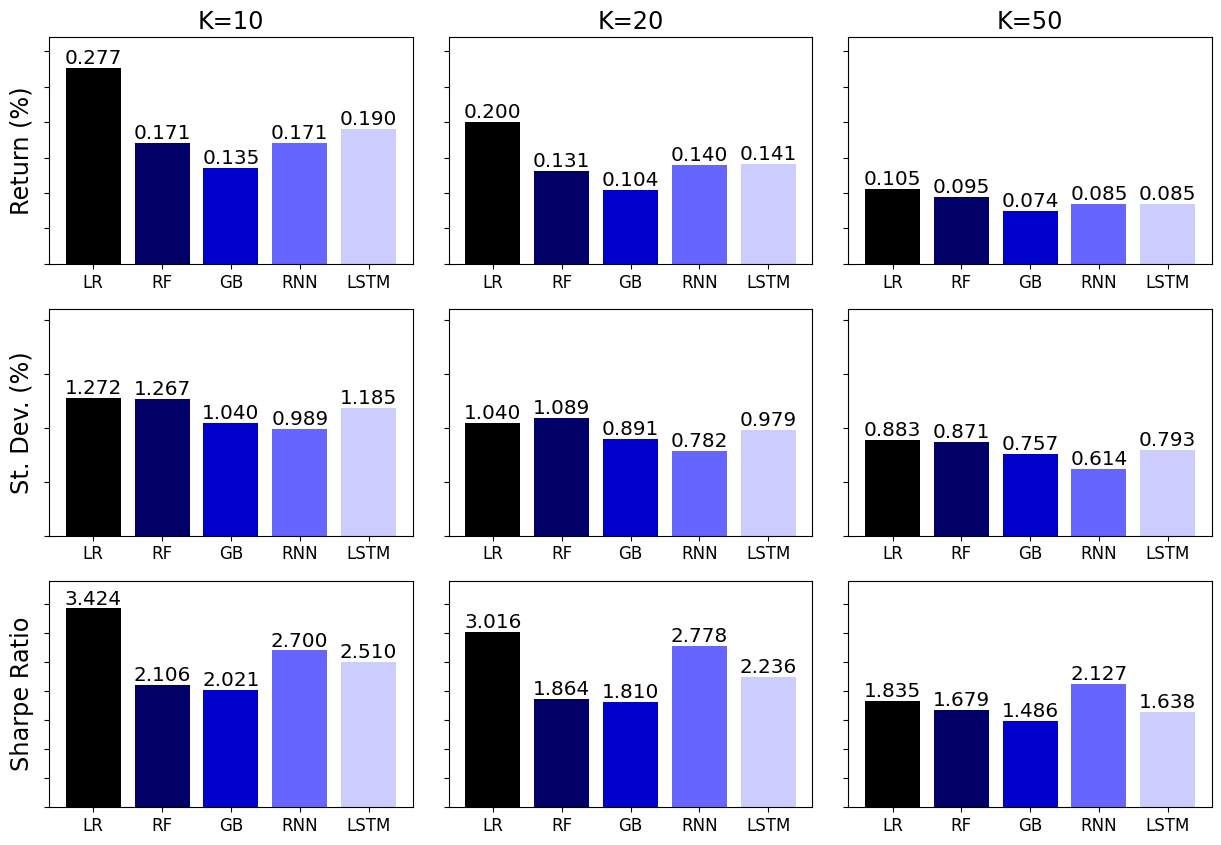

In [154]:
dict = dict_df_metrics_SESI

# Define colors for each bar category
colors = ['red', 'blue', 'green', 'orange', 'yellow']
# colors = [(1, 0, 0, 1), (0, 0, 1, 1), (0, 1, 0, 1), (1, 0.5, 0, 1), (1, 1, 0, 1)]  # red, blue, green, orange, yellow # last number is the alpha transparency # Lower values for the first 3 lead to darker colors
# colors = [(0.75, 0, 0, 1), (0, 0, 0.75, 1), (0, 0.75, 0, 1), (0.75, 0.375, 0, 1), (0.75, 0.75, 0, 1)] 
colors = [(1.0, 0.0, 0.0), (0.75, 0.0, 0.25), (0.5, 0.0, 0.5), (0.25, 0.0, 0.75), (0.0, 0.0, 1.0)]     # from red to blue
# colors = [(0.0, 0.0, 1.0), (0.2, 0.2, 0.6), (0.4, 0.4, 0.2),(0.6, 0.6, 0.0),(1.0, 1.0, 0.0)]
# colors = [(0.0, 0.0, 1.0), (0.0, 0.25, 0.5), (0.0, 0.5, 0.0), (0.0, 0.75, 0.0), (0.0, 1.0, 0.0)]
colors = [(0.0, 0.0, 0), (0.0, 0.0, 0.25), (0.0, 0.0, 0.5), (0.0, 0.0, 0.75), (0.0, 0.0, 1.0)]        # Black to blue
#colors = [(1.0, 1.0, 1.0), (0.75, 0.75, 1.0), (0.5, 0.5, 1.0), (0.25, 0.25, 1.0), (0.0, 0.0, 1.0)]    # White to blue    
colors = [(0.0, 0.0, 0), (0.0, 0.0, 0.40), (0.0, 0.0, 0.80), (0.4, 0.4, 1), (0.8, 0.8, 1.0)]        # Black to light blue        # Best colours


# Create subplots with 3 rows and 3 columns
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

metrics = ["Return (%)", 'St. Dev. (%)', "Sharpe Ratio"]
keys = ["10", "20", "50"]

# Define Y-axis limits for each metric
y_lims = {"Return (%)": [0, 0.32], 'St. Dev. (%)': [0, 2.1], "Sharpe Ratio": [0, 3.9]}

for i, metric in enumerate(metrics):
    for j, key in enumerate(keys):
        bars = axes[i, j].bar(dict[key].columns, dict[key].loc[metric], color=colors)
        if metric == "Return (%)":
            axes[i, j].set_title(f"K={key}", fontsize = "xx-large")
        # axes[i, j].set_xlabel(key)
        if key == "10":
            axes[i, j].set_ylabel(metric, fontsize = "xx-large")

        axes[i, j].set_ylim(y_lims[metric])  # set the y-axis limit
        axes[i, j].set_yticklabels([])

        # Adjust the size of x and y tick labels
        axes[i, j].tick_params(axis='x', labelsize=12)

        for bar in bars:
            yval = bar.get_height()
            # axes[i, j].text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom', fontsize = "large")
            axes[i, j].text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.3f}", ha='center', va='bottom', fontsize="x-large")


plt.show()
